In [1]:
import os
import time
import gzip
import random

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score as acc

In [2]:
DATA_FOLDER = "./data"

MNIST_FOLDER = os.path.join(DATA_FOLDER, "mnist")
training_images_file = 'train-images-idx3-ubyte.gz'  # training set images (9912422 bytes)
training_labels_file = 'train-labels-idx1-ubyte.gz'  # training set labels (28881 bytes)
test_images_file = 't10k-images-idx3-ubyte.gz'  # test set images (1648877 bytes)
test_labels_file = 't10k-labels-idx1-ubyte.gz'  # test set labels (4542 bytes)

In [3]:
def load_mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels). 
        Rows are examples. 
        Columns of images are pixel values.
        Columns of labels are a onehot encoding of the correct class.
    """
    # url = 'http://yann.lecun.com/exdb/mnist/'

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        # return _onehot(integer_labels)
        return integer_labels

    train_images = _images(os.path.join(path, training_images_file))
    train_labels = _labels(os.path.join(path, training_labels_file))
    test_images = _images(os.path.join(path, test_images_file))
    test_labels = _labels(os.path.join(path, test_labels_file))

    return train_images, train_labels, test_images, test_labels

In [4]:
# the data, split between train and test sets
(x_train, y_train, x_test, y_test) = load_mnist(MNIST_FOLDER)

In [5]:
display(x_train.shape)
display(x_test.shape)
display(y_train.shape)
display(y_test.shape)

(60000, 784)

(10000, 784)

(60000,)

(10000,)

In [6]:
# def accuracy(y_tests, y_preds):
#     correct = np.sum(np.array([y_test==y_pred for y_test, y_pred in zip(y_tests, y_preds)]))
#     return correct/len(y_tests)

def accuracy(y_tests, y_preds):
    correct = 0
    for y_test, y_pred in zip(y_tests, y_preds):
        if y_test==y_pred:
            correct+=1
    
    return correct/len(y_tests)

In [7]:
# data parameters
input_shape = (28, 28, 1)
num_classes = 10
n_samples = x_train.shape[0]
m_size = x_train.shape[1]

# training parameters
lambda_values = [0.01, 0.1, 1, 10]
max_iterations = 1000000
# max_iterations = 10000

accuracies_for_lambdas = {}
weights_for_lambdas = {}

In [19]:
%%time

for l in lambda_values:
    start = time.time()
    w = np.random.randn(num_classes, m_size)
    accuracy_values = []
    print("\nlamda: ", l, "\n***********")
    for t in range(max_iterations):
        lr = 1/(t+1)
        i = np.random.randint(0, n_samples) 
        x = x_train[i][np.newaxis, ...]
        y = y_train[i]
        
        scores = np.matmul(x, w.T)
        ones = np.ones(num_classes)
        ones[y] = 0
        svm_scores = scores - scores[0,y] + ones[np.newaxis,...]
        
        pred = np.argmax(svm_scores, axis=1)[0]
        w[pred] -= lr * x[0]
        w[y] += lr * x[0]
        dim_norms = np.linalg.norm(w, axis=0)
        
        lr_lambda = lr*l
        
        for dim in range(m_size):
            if dim_norms[dim] <= lr_lambda:
                w[:, dim] = w[:, dim] * 0
            else:
                w[:, dim] = w[:, dim] * (1 - (lr_lambda/dim_norms[dim]))
        
        if not t % 1000:
            y_pred = np.argmax(np.matmul(x_test, w.T), axis=1)
            accuracy_values.append(accuracy(y_test, y_pred))
        if not t % 100000:
            print("lambda: ", l, ",\titeration: ", t)
            print("time taken for 100000 iterations {}: ".format(l), time.time() - start)
    
    print("time taken for lambda {}: ".format(l), time.time() - start)
    
    y_pred = np.argmax(np.matmul(x_test, w.T), axis=1)
    accuracy_values.append(accuracy(y_test, y_pred))
    accuracies_for_lambdas[l] = accuracy_values
    weights_for_lambdas[l] = w


lamda:  0.01 
***********
lambda:  0.01 ,	iteration:  0
lambda:  0.01 ,	iteration:  100000
lambda:  0.01 ,	iteration:  200000
lambda:  0.01 ,	iteration:  300000
lambda:  0.01 ,	iteration:  400000
lambda:  0.01 ,	iteration:  500000
lambda:  0.01 ,	iteration:  600000
lambda:  0.01 ,	iteration:  700000
lambda:  0.01 ,	iteration:  800000
lambda:  0.01 ,	iteration:  900000
time taken for lambda 0.01:  1198.9620399475098

lamda:  0.1 
***********
lambda:  0.1 ,	iteration:  0
lambda:  0.1 ,	iteration:  100000
lambda:  0.1 ,	iteration:  200000
lambda:  0.1 ,	iteration:  300000
lambda:  0.1 ,	iteration:  400000
lambda:  0.1 ,	iteration:  500000
lambda:  0.1 ,	iteration:  600000
lambda:  0.1 ,	iteration:  700000
lambda:  0.1 ,	iteration:  800000
lambda:  0.1 ,	iteration:  900000
time taken for lambda 0.1:  1215.519582271576

lamda:  1 
***********
lambda:  1 ,	iteration:  0
lambda:  1 ,	iteration:  100000
lambda:  1 ,	iteration:  200000
lambda:  1 ,	iteration:  300000
lambda:  1 ,	iteration:  4

<AxesSubplot:>

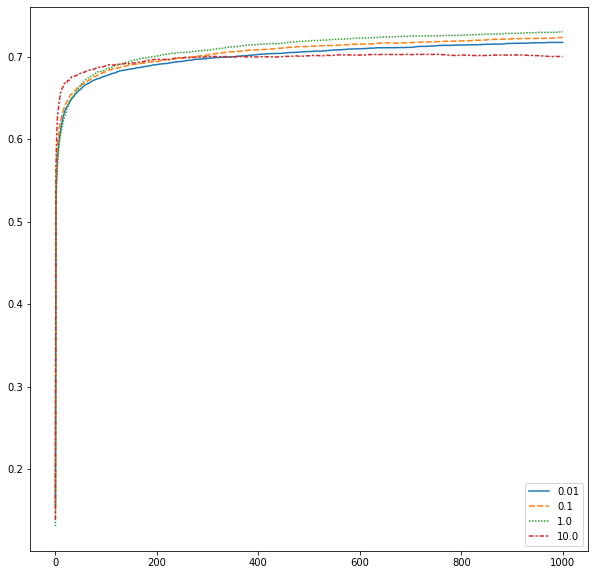

In [22]:
df = pd.DataFrame(accuracies_for_lambdas)

plt.figure(figsize=(10,10))
sns.lineplot(data=df)

In [23]:
from matplotlib import colors

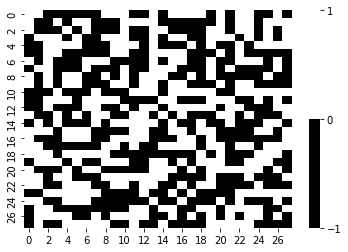

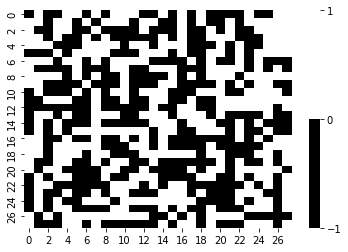

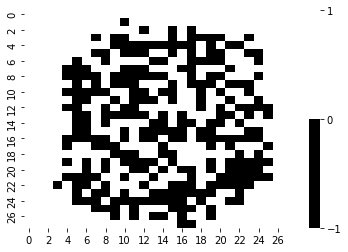

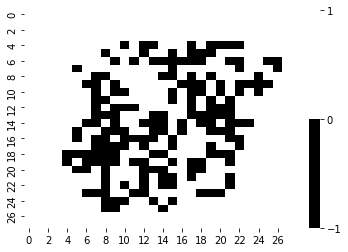

In [24]:
# Black and White
cmap = colors.ListedColormap(['k', 'w'])
# Uses the bounds to normalize values to either pick 'w' or 'k'
bounds = [-1., 0., 1.]
norm = colors.BoundaryNorm(bounds, cmap.N)

for l in lambda_values:
    w = weights_for_lambdas[l]
    pixelmap = np.reshape(np.mean(w, axis=0), (28,28))
    plt.figure()
    sns.heatmap(pixelmap, cmap=cmap, norm=norm)
    plt.show()

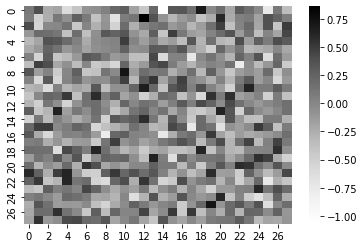

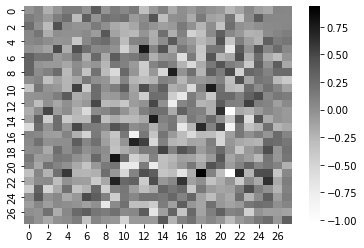

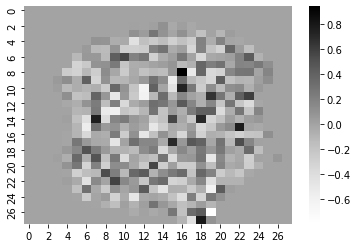

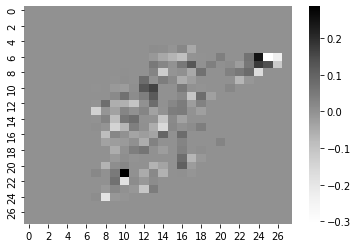

In [25]:
for l in lambda_values:
    w = weights_for_lambdas[l]
    pixelmap = np.reshape(np.mean(w, axis=0), (28,28))
    plt.figure()
    sns.heatmap(pixelmap, cmap='Greys')
    plt.show()

In [26]:
import pickle as pkl

In [27]:
with open("models/mnist/values.pickle", 'wb') as f:
    pkl.dump(weights_for_lambdas, f)
    pkl.dump(accuracies_for_lambdas, f)

In [28]:
with open("models/mnist/values.pickle", 'rb') as f:
    weights_for_lambdas = pkl.load(f)
    accuracies_for_lambdas = pkl.load(f)